<a href="https://colab.research.google.com/github/Nithinsp2001/GAN_Training-Model/blob/main/2_Digit_Class_Controlled_Image_Generation_with_Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.61MB/s]


[Epoch 0/50] [Batch 0] D_loss: 0.7018, G_loss: 0.6702
[Epoch 0/50] [Batch 200] D_loss: 0.0780, G_loss: 5.4724
[Epoch 0/50] [Batch 400] D_loss: 0.0384, G_loss: 13.4168
[Epoch 0/50] [Batch 600] D_loss: 0.0059, G_loss: 20.3293
[Epoch 0/50] [Batch 800] D_loss: 0.0541, G_loss: 17.5931
[Epoch 1/50] [Batch 0] D_loss: 0.0247, G_loss: 17.9691
[Epoch 1/50] [Batch 200] D_loss: 0.1055, G_loss: 19.0009
[Epoch 1/50] [Batch 400] D_loss: 0.0395, G_loss: 17.8045
[Epoch 1/50] [Batch 600] D_loss: 0.1382, G_loss: 16.6125
[Epoch 1/50] [Batch 800] D_loss: 0.0632, G_loss: 11.5370
[Epoch 2/50] [Batch 0] D_loss: 0.1975, G_loss: 15.7732
[Epoch 2/50] [Batch 200] D_loss: 0.0770, G_loss: 9.3753
[Epoch 2/50] [Batch 400] D_loss: 0.0683, G_loss: 9.8132
[Epoch 2/50] [Batch 600] D_loss: 0.3604, G_loss: 13.6007
[Epoch 2/50] [Batch 800] D_loss: 0.1207, G_loss: 17.3703
[Epoch 3/50] [Batch 0] D_loss: 0.0194, G_loss: 21.6779
[Epoch 3/50] [Batch 200] D_loss: 0.1322, G_loss: 14.7769
[Epoch 3/50] [Batch 400] D_loss: 0.0596, G_

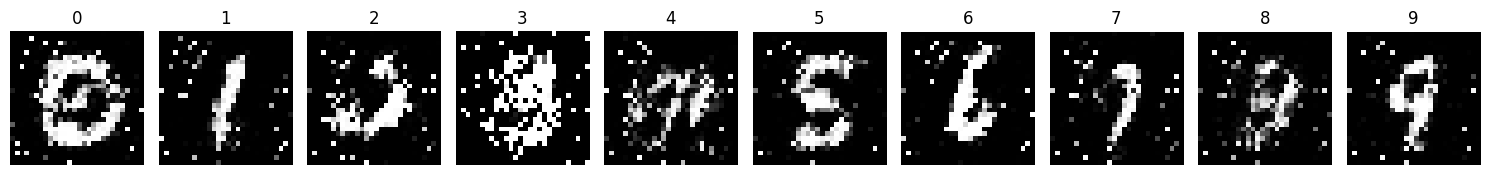

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 100
num_classes = 10
image_size = 28*28
batch_size = 64
epochs = 50  # You can increase this for better results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
train_loader = DataLoader(datasets.MNIST("./data", train=True, download=True, transform=transform),
                          batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, image_size),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], dim=1)
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(image_size + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_emb(labels)
        x = torch.cat([img, c], dim=1)
        return self.model(x)

# Initialize
G = Generator().to(device)
D = Discriminator().to(device)

# Loss & optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

# Training
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)
        real_imgs = imgs.view(batch_size, -1).to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Train Generator
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        gen_imgs = G(z, gen_labels)

        optimizer_G.zero_grad()
        g_loss = criterion(D(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(D(real_imgs, labels), valid)
        fake_loss = criterion(D(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 200 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

# Visualize 1 sample per digit
G.eval()
z = torch.randn(10, latent_dim, device=device)
labels = torch.arange(0, 10, dtype=torch.long, device=device)
gen_imgs = G(z, labels).detach().cpu().view(-1, 1, 28, 28)

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(gen_imgs[i].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"{i}")
plt.tight_layout()
plt.show()